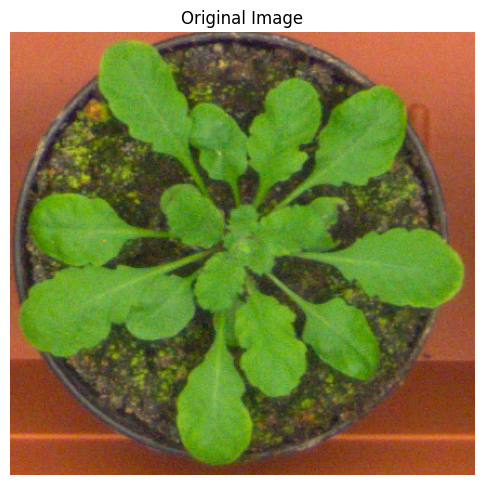

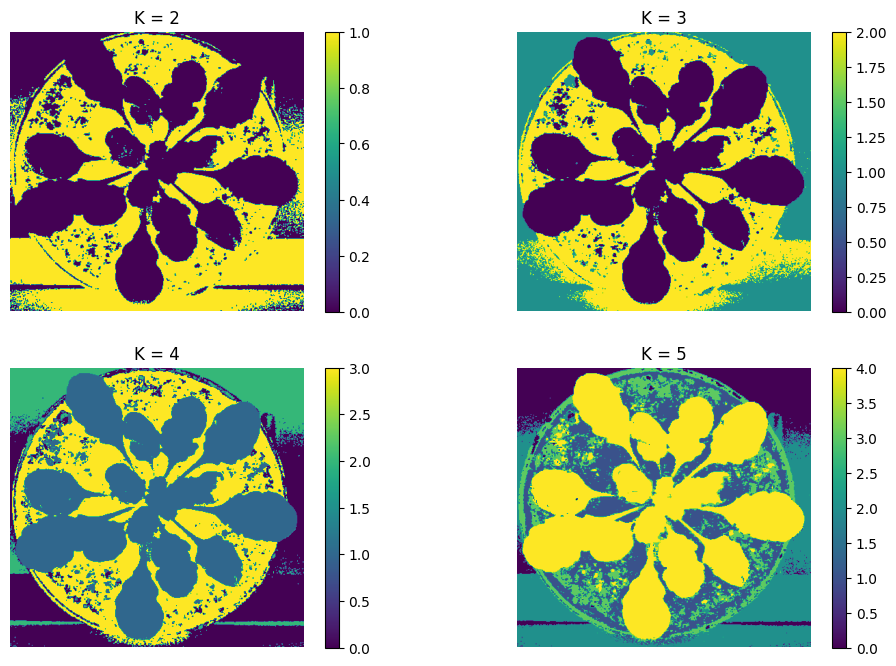

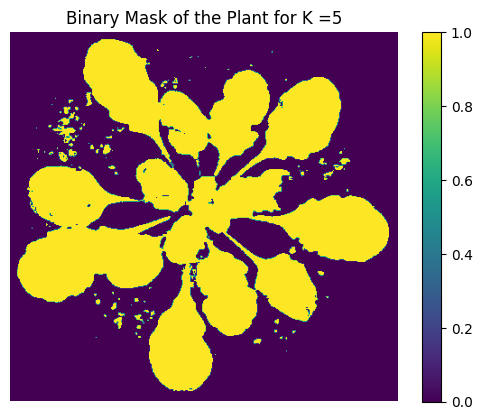

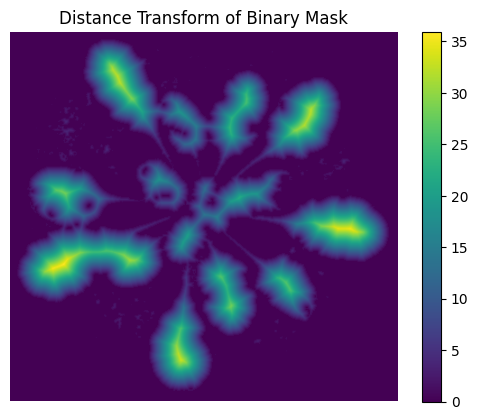

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

image = cv2.imread("3.png")  
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR image to RGB

plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

pixels = rgb_image.reshape(-1, 3).astype(np.float32)

k_values = [2, 3, 4, 5]  # List of k values to try
segmented_images = []
for k in k_values:
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.reshape(rgb_image.shape[:2])
    segmented_images.append(segmented_image)

plt.figure(figsize=(12, 8))
for i, segmented_image in enumerate(segmented_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title(f"K = {k_values[i]}")
    plt.colorbar()
    plt.axis('off')
plt.show()



chosen_segmentation = segmented_images[3]  # Use index 0 for k = 2, index 1 for k = 3, and so on

plant_segment_label = 4 # Replace with the actual segment label of the plant

plant_mask = np.where(chosen_segmentation == plant_segment_label, 1, 0)

plt.imshow(plant_mask, cmap='viridis')
plt.title("Binary Mask of the Plant for K =5")
plt.colorbar()
plt.axis('off')
plt.show()

# Compute the distance transform of the binary mask
distance_transform = distance_transform_edt(plant_mask)

# Display the distance transform
plt.imshow(distance_transform, cmap='viridis')
plt.title("Distance Transform of Binary Mask")
plt.colorbar()
plt.axis('off')
plt.show()



minRadius: 0
maxRadius: 48


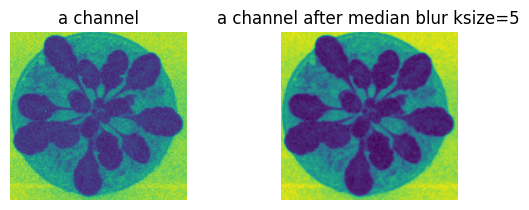

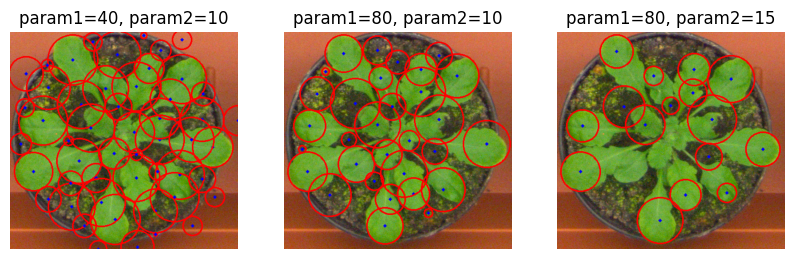

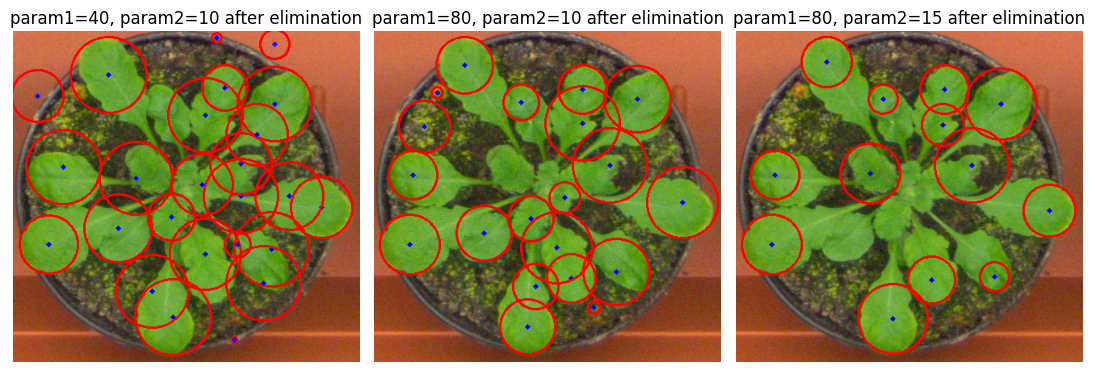

In [6]:

# Convert the image to Lab color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

# Extract the a* channel
a_channel = lab_image[:, :, 1]
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('a channel')
plt.imshow(a_channel, cmap='viridis')

# Apply median filtering to the a* channel
filtered_a = cv2.medianBlur(a_channel, 5)
plt.subplot(2, 2, 2)
plt.axis('off')
plt.title('a channel after median blur ksize=5')
plt.imshow(filtered_a, cmap='viridis')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image
thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]

_, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Compute the distance transform of the binary mask
distance_transform = cv2.distanceTransform(thresholded, cv2.DIST_L2, 3)

# Find the maximum value of the distance transform
max_value = np.max(distance_transform)

# Find the value of the distance transform at the centers of the smaller leaves
smaller_leaves = np.where(thresholded == 255)
centers = np.array([(x, y) for x, y in zip(smaller_leaves[0][:249], smaller_leaves[1][:249])])
values = distance_transform[centers]

# Choose the minRadius and maxRadius parameters
min_radius = int(np.min(values))
max_radius = int(1.25 * max_value)

# Print the minRadius and maxRadius parameters
print("minRadius:", min_radius)
print("maxRadius:", max_radius)

param_sets = [
    (40, 10),
    (80, 10),
    (80, 15)
]


# Perform circle detection for each parameter set
results = []
for param1, param2 in param_sets:

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(filtered_a, cv2.HOUGH_GRADIENT, dp=1, minDist=0.1*min(image.shape[:2]), param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)
    results.append((circles, param1, param2))
    
    
    
# Visualize the results
fig, axs = plt.subplots(1, len(results), figsize=(10, 5))
for i, (circles, param1, param2) in enumerate(results):
    output_image = image.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(output_image, center, radius, (0, 0, 255), 2)
            cv2.circle(output_image, center, 1, (255, 0, 0), 3)
            axs[i].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
            axs[i].axis('off')
            axs[i].set_title(f"param1={param1}, param2={param2}")
            
            

fig, axs = plt.subplots(1, len(results), figsize=(11, 5))
# Detect circles using HoughCircles for each parameter setting
for i, (param1, param2) in enumerate(param_sets):
    
    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(filtered_a, cv2.HOUGH_GRADIENT, dp=1, minDist=0.1 * min(image.shape[:2]),
                               param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

    # Visualize the detected circles and middle points as different colors
    if circles is not None:
        circles = np.round(circles[0, :]).astype(int)
        output_image = image.copy()
        
        for (x, y, r) in circles:
            # Check if the circle's center is inside the plant mask
            if y < binary_mask.shape[0] and x < binary_mask.shape[1] and binary_mask[y, x] == 255:
                # Draw the circle with its respective color
                cv2.circle(output_image, (x, y), r, (0, 0, 255), 2)
                # Draw the middle point with a different color
                cv2.circle(output_image, (x, y), 1, (255, 0, 0), 3)

        # Display the image with detected circles and corresponding parameters
        #axs[i].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        axs[i].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f"param1={param1}, param2={param2} after elimination")
        axs[i].axis('off')
plt.tight_layout()
plt.show()